# LIF Model

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
my_layout = widgets.Layout()

#### Helper Functions

In [4]:
# @title Plotting Functions

def plot_volt_trace(pars, v, sp):
  """
  Plot trajetory of membrane potential for a single neuron

  Expects:
  pars   : parameter dictionary
  v      : volt trajetory
  sp     : spike train

  Returns:
  figure of the membrane potential trajetory for a single neuron
  """

  V_th = pars['V_th']
  dt, range_t = pars['dt'], pars['range_t']
  if sp.size:
    sp_num = (sp / dt).astype(int) - 1
    v[sp_num] += 20  # draw nicer spikes

  plt.plot(pars['range_t'], v, 'b')
  plt.axhline(V_th, 0, 1, color='k', ls='--')
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
             loc=[1.05, 0.75])
  plt.ylim([-80, -40])
  plt.show()


def plot_GWN(pars, I_GWN):
  """
  Args:
    pars  : parameter dictionary
    I_GWN : Gaussian white noise input

  Returns:
    figure of the gaussian white noise input
  """

  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  plt.plot(pars['range_t'][::3], I_GWN[::3], 'b')
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$I_{GWN}$ (pA)')
  plt.subplot(122)
  plot_volt_trace(pars, v, sp)
  plt.tight_layout()
  plt.show()


def my_hists(isi1, isi2, cv1, cv2, sigma1, sigma2):
  """
  Args:
    isi1 : vector with inter-spike intervals
    isi2 : vector with inter-spike intervals
    cv1  : coefficient of variation for isi1
    cv2  : coefficient of variation for isi2

  Returns:
    figure with two histograms, isi1, isi2

  """
  plt.figure(figsize=(11, 4))
  my_bins = np.linspace(10, 30, 20)
  plt.subplot(121)
  plt.hist(isi1, bins=my_bins, color='b', alpha=0.5)
  plt.xlabel('ISI (ms)')
  plt.ylabel('count')
  plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma1, cv1))

  plt.subplot(122)
  plt.hist(isi2, bins=my_bins, color='b', alpha=0.5)
  plt.xlabel('ISI (ms)')
  plt.ylabel('count')
  plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma2, cv2))
  plt.tight_layout()
  plt.show()

#### LIF

In [6]:
def default_pars(**kwargs):
  pars = {}

  # typical neuron parameters#
  pars['V_th'] = -55.     # spike threshold [mV]
  pars['V_reset'] = -75.  # reset potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms]
  pars['g_L'] = 10.       # leak conductance [nS]
  pars['V_init'] = -75.   # initial potential [mV]
  pars['E_L'] = -75.      # leak reversal potential [mV]
  pars['tref'] = 2.       # refractory time (ms)

  # simulation parameters #
  pars['T'] = 400.  # Total duration of simulation [ms]
  pars['dt'] = .1   # Simulation time step [ms]

  # external parameters if any #
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

  return pars


pars = default_pars()
print(pars)

{'V_th': -55.0, 'V_reset': -75.0, 'tau_m': 10.0, 'g_L': 10.0, 'V_init': -75.0, 'E_L': -75.0, 'tref': 2.0, 'T': 400.0, 'dt': 0.1, 'range_t': array([0.000e+00, 1.000e-01, 2.000e-01, ..., 3.997e+02, 3.998e+02,
       3.999e+02], shape=(4000,))}


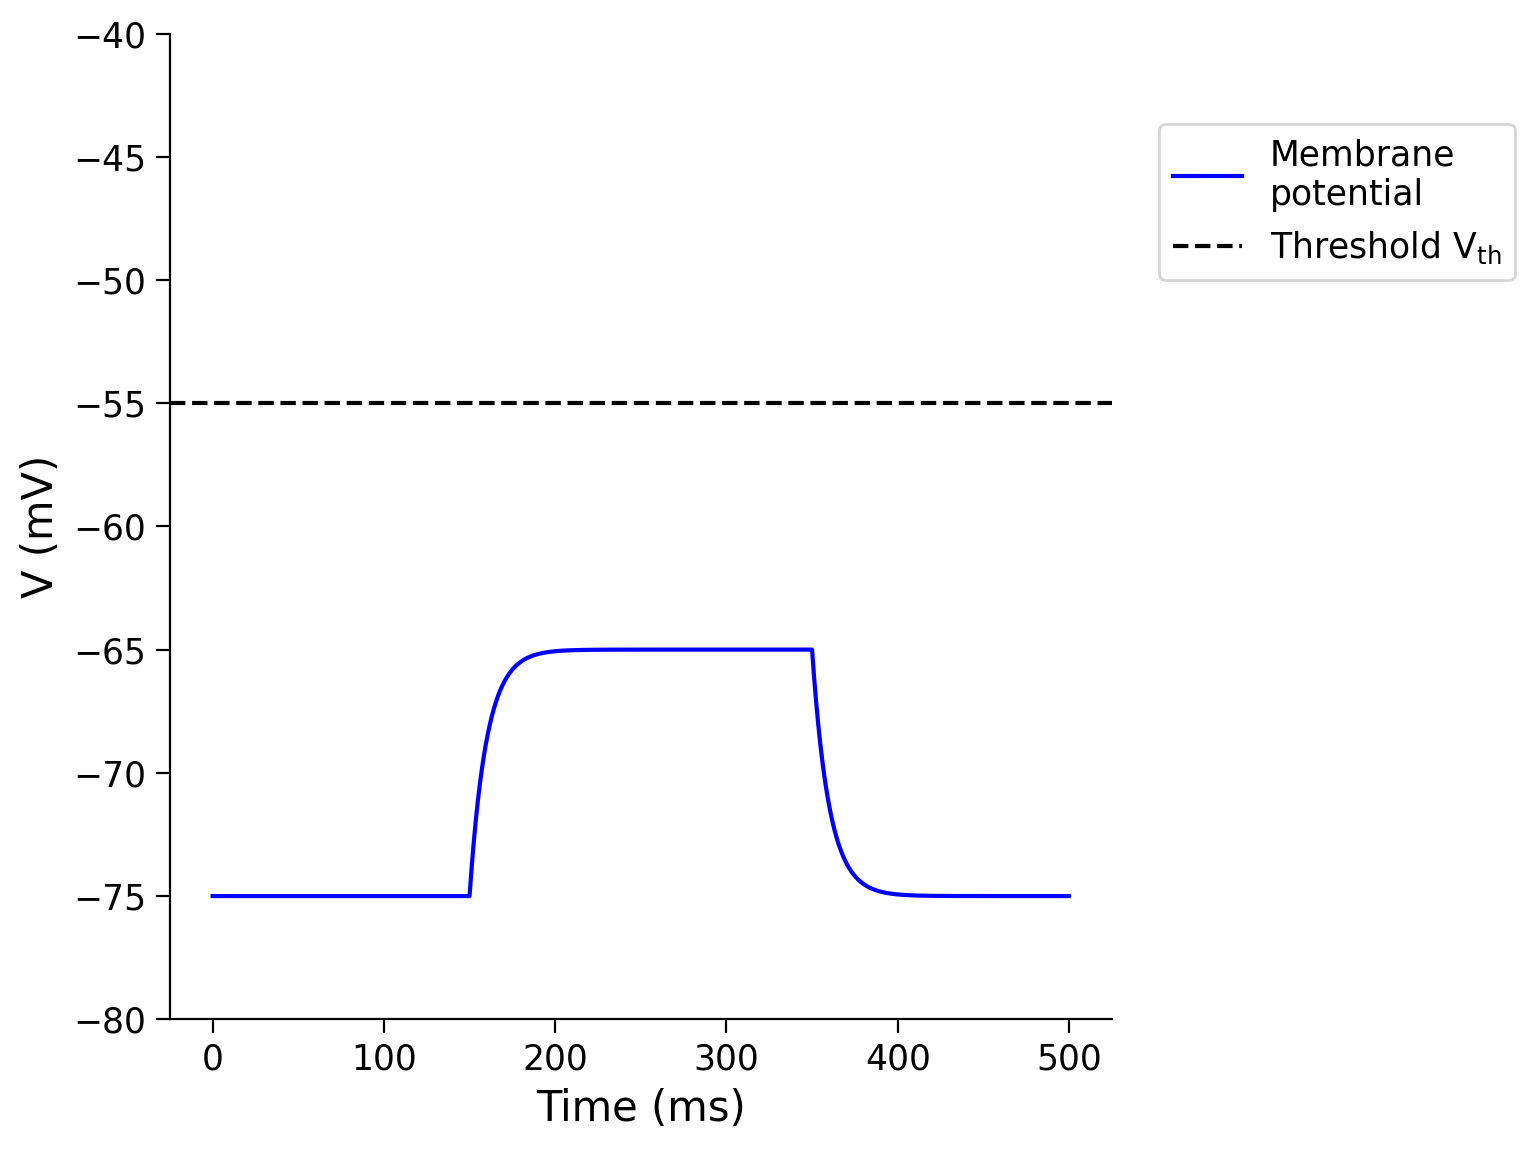

In [7]:
def run_LIF(pars, Iinj, stop=False):
  """
  Simulate the LIF dynamics with external input current

  Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value
                 or an array
    stop       : boolean. If True, use a current pulse

  Returns:
    rec_v      : membrane potential
    rec_sp     : spike times
  """

  # Set parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, E_L = pars['V_init'], pars['E_L']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tref = pars['tref']

  # Initialize voltage
  v = np.zeros(Lt)
  v[0] = V_init

  # Set current time course
  Iinj = Iinj * np.ones(Lt)

  # If current pulse, set beginning and end to 0
  if stop:
    Iinj[:int(len(Iinj) / 2) - 1000] = 0
    Iinj[int(len(Iinj) / 2) + 1000:] = 0

  # Loop over time
  rec_spikes = []  # record spike times
  tr = 0.  # the count for refractory duration

  for it in range(Lt - 1):

    if tr > 0:  # check if in refractory period
      v[it] = V_reset  # set voltage to reset
      tr = tr - 1 # reduce running counter of refractory period

    elif v[it] >= V_th:  # if voltage over threshold
      rec_spikes.append(it)  # record spike event
      v[it] = V_reset  # reset voltage
      tr = tref / dt  # set refractory time

    

    # Calculate the increment of the membrane potential
    dv = dt * (-(v[it] - E_L) + Iinj[it] / g_L) * (1 / tau_m)

    # Update the membrane potential
    v[it + 1] = v[it] + dv

  # Get spike times in ms
  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes


# Get parameters
pars = default_pars(T=500)

# Simulate LIF model
v, sp = run_LIF(pars, Iinj=100, stop=True)

# Visualize
plot_volt_trace(pars, v, sp)

In [8]:
# @markdown Execute to enable helper function `my_GWN`

def my_GWN(pars, mu, sig, myseed=False):
  """
  Function that generates Gaussian white noise input

  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same
                 random number sequence

  Returns:
    I          : Gaussian white noise input
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # Generate GWN
  # we divide here by 1000 to convert units to sec.
  I_gwn = mu + sig * np.random.randn(Lt) / np.sqrt(dt / 1000.)

  return I_gwn

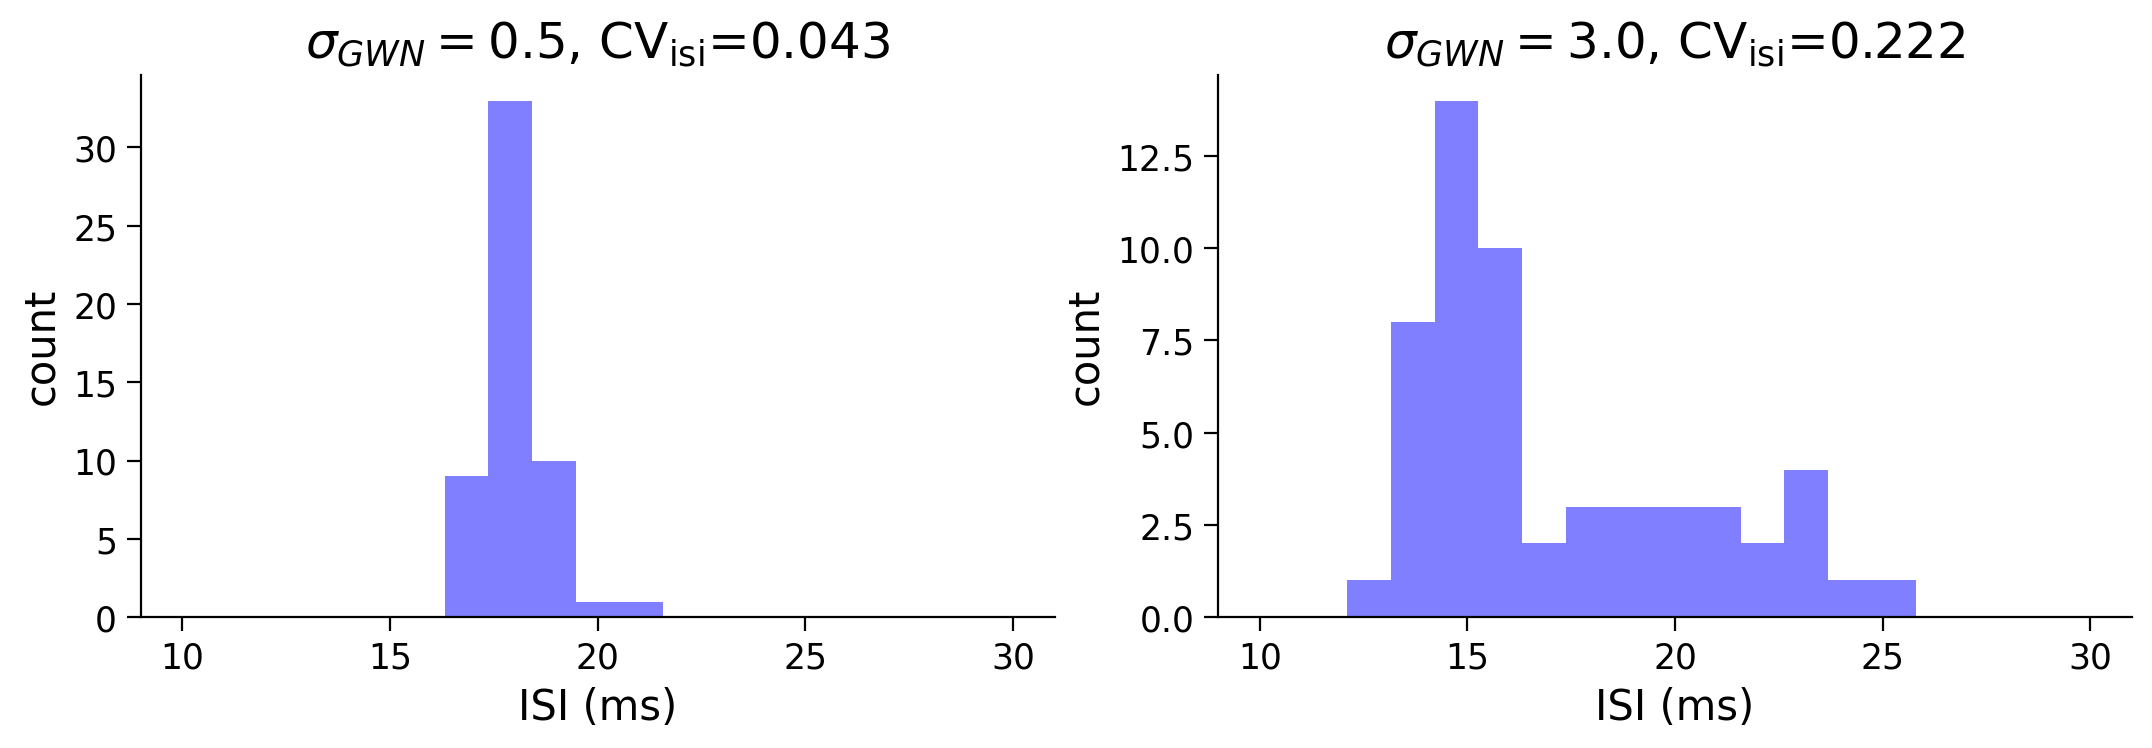

In [9]:
def isi_cv_LIF(spike_times):
  """
  Calculates the interspike intervals (isi) and
  the coefficient of variation (cv) for a given spike_train

  Args:
    spike_times : (n, ) vector with the spike times (ndarray)

  Returns:
    isi         : (n-1,) vector with the inter-spike intervals (ms)
    cv          : coefficient of variation of isi (float)

  """
  
  ## compute the membrane potential v, spike train sp #
  
  
  
  if len(spike_times) >= 2:
    # Compute isi
    isi = np.diff(spike_times)
    # Compute cv
    cv = np.std(isi) / np.mean(isi)
  else:
    isi = np.nan
    cv = np.nan

  return isi, cv


# Set parameters
pars = default_pars(T=1000.)
mu_gwn = 250
sig_gwn1 = 0.5
sig_gwn2 = 3.0

# Run LIF model for sigma = 0.5
I_GWN1 = my_GWN(pars, mu=mu_gwn, sig=sig_gwn1, myseed=2020)
_, sp1 = run_LIF(pars, Iinj=I_GWN1)

# Run LIF model for sigma = 3
I_GWN2 = my_GWN(pars, mu=mu_gwn, sig=sig_gwn2, myseed=2020)
_, sp2 = run_LIF(pars, Iinj=I_GWN2)

# Compute ISIs/CV
isi1, cv1 = isi_cv_LIF(sp1)
isi2, cv2 = isi_cv_LIF(sp2)

# Visualize
my_hists(isi1, isi2, cv1, cv2, sig_gwn1, sig_gwn2)

In [10]:
def my_OU(pars, mu, sig, myseed=False):
  """
  Function that produces Ornstein-Uhlenbeck input

  Args:
    pars       : parameter dictionary
    sig        : noise amplitute
    myseed     : random seed. int or boolean

  Returns:
    I_ou       : Ornstein-Uhlenbeck input current
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tau_ou = pars['tau_ou']  # [ms]

  # set random seed
  if myseed:
    np.random.seed(seed=myseed)
  else:
    np.random.seed()

  # Initialize
  noise = np.random.randn(Lt)
  I_ou = np.zeros(Lt)
  I_ou[0] = noise[0] * sig

  # generate OU
  for it in range(Lt-1):
    I_ou[it+1] = I_ou[it] + (dt / tau_ou) * (mu - I_ou[it]) + np.sqrt(2 * dt / tau_ou) * sig * noise[it + 1]

  return I_ou


#### Input Correlation

In [11]:
import time

In [12]:
def example_plot_myCC():
  pars = default_pars(T=50000, dt=.1)

  c = np.arange(10) * 0.1
  r12 = np.zeros(10)
  for i in range(10):
    I1gL, I2gL = correlate_input(pars, mu=20.0, sig=7.5, c=c[i])
    r12[i] = my_CC(I1gL, I2gL)

  plt.figure()
  plt.plot(c, r12, 'bo', alpha=0.7, label='Simulation', zorder=2)
  plt.plot([-0.05, 0.95], [-0.05, 0.95], 'k--', label='y=x',
           dashes=(2, 2), zorder=1)
  plt.xlabel('True CC')
  plt.ylabel('Sample CC')
  plt.legend(loc='best')
  plt.show()


def my_raster_Poisson(range_t, spike_train, n):
  """
  Ffunction generates and plots the raster of the Poisson spike train

  Args:
    range_t     : time sequence
    spike_train : binary spike trains, with shape (N, Lt)
    n           : number of Poisson trains plot

  Returns:
    Raster plot of the spike train
  """

  # find the number of all the spike trains
  N = spike_train.shape[0]

  # n should smaller than N:
  if n > N:
    print('The number n exceeds the size of spike trains')
    print('The number n is set to be the size of spike trains')
    n = N

  # plot rater
  plt.figure()
  i = 0
  while i < n:
    if spike_train[i, :].sum() > 0.:
      t_sp = range_t[spike_train[i, :] > 0.5]  # spike times
      plt.plot(t_sp, i * np.ones(len(t_sp)), 'k|', ms=10, markeredgewidth=2)
    i += 1
  plt.xlim([range_t[0], range_t[-1]])
  plt.ylim([-0.5, n + 0.5])
  plt.xlabel('Time (ms)', fontsize=12)
  plt.ylabel('Neuron ID', fontsize=12)
  plt.show()

def plot_c_r_LIF(c, r, mycolor, mylabel):
  z = np.polyfit(c, r, deg=1)
  c_range = np.array([c.min() - 0.05, c.max() + 0.05])
  plt.plot(c, r, 'o', color=mycolor, alpha=0.7, label=mylabel, zorder=2)
  plt.plot(c_range, z[0] * c_range + z[1], color=mycolor, zorder=1)

#### Helper Functions

In [17]:
def correlate_input(pars, mu=20., sig=7.5, c=0.3):
  """
  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    c.         : correlation coefficient ~[0, 1]

  Returns:
    I1gL, I2gL : two correlated inputs with corr. coe. c
  """

  # generate Gaussian whute noise xi_1, xi_2, xi_c
  xi_1 = my_GWN(pars, sig)
  xi_2 = my_GWN(pars, sig)
  xi_c = my_GWN(pars, sig)

  # Generate two correlated inputs by Equation. (1)
  I1gL = mu + np.sqrt(1. - c) * xi_1 + np.sqrt(c) * xi_c
  I2gL = mu + np.sqrt(1. - c) * xi_2 + np.sqrt(c) * xi_c

  return I1gL, I2gL

def LIF_output_cc(pars, mu, sig, c, bin_size, n_trials=20):
  """ Simulates two LIF neurons with correlated input and computes output correlation

  Args:
  pars       : parameter dictionary
  mu         : noise baseline (mean)
  sig        : noise amplitute (standard deviation)
  c          : correlation coefficient ~[0, 1]
  bin_size   : bin size used for time series
  n_trials   : total simulation trials

  Returns:
  r          : output corr. coe.
  sp_rate    : spike rate
  sp1        : spike times of neuron 1 in the last trial
  sp2        : spike times of neuron 2 in the last trial
  """

  r12 = np.zeros(n_trials)
  sp_rate = np.zeros(n_trials)
  for i_trial in range(n_trials):
    I1gL, I2gL = correlate_input(pars, mu, sig, c)
    _, sp1 = run_LIF(pars, pars['g_L'] * I1gL)
    _, sp2 = run_LIF(pars, pars['g_L'] * I2gL)

    my_bin = np.arange(0, pars['T'], bin_size)

    sp1_count, _ = np.histogram(sp1, bins=my_bin)
    sp2_count, _ = np.histogram(sp2, bins=my_bin)

    r12[i_trial] = my_CC(sp1_count[::20], sp2_count[::20])
    sp_rate[i_trial] = len(sp1) / pars['T'] * 1000.

  return r12.mean(), sp_rate.mean(), sp1, sp2


def my_GWN(pars, sig, myseed=False):
  """
  Function that calculates Gaussian white noise inputs

  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same random number sequence

  Returns:
    I          : Gaussian white noise input
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Set random seed. You can fix the seed of the random number generator so
  # that the results are reliable however, when you want to generate multiple
  # realization make sure that you change the seed for each new realization
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate GWN
  # we divide here by 1000 to convert units to sec.
  I_GWN = sig * np.random.randn(Lt) * np.sqrt(pars['tau_m'] / dt)

  return I_GWN

#### Sync

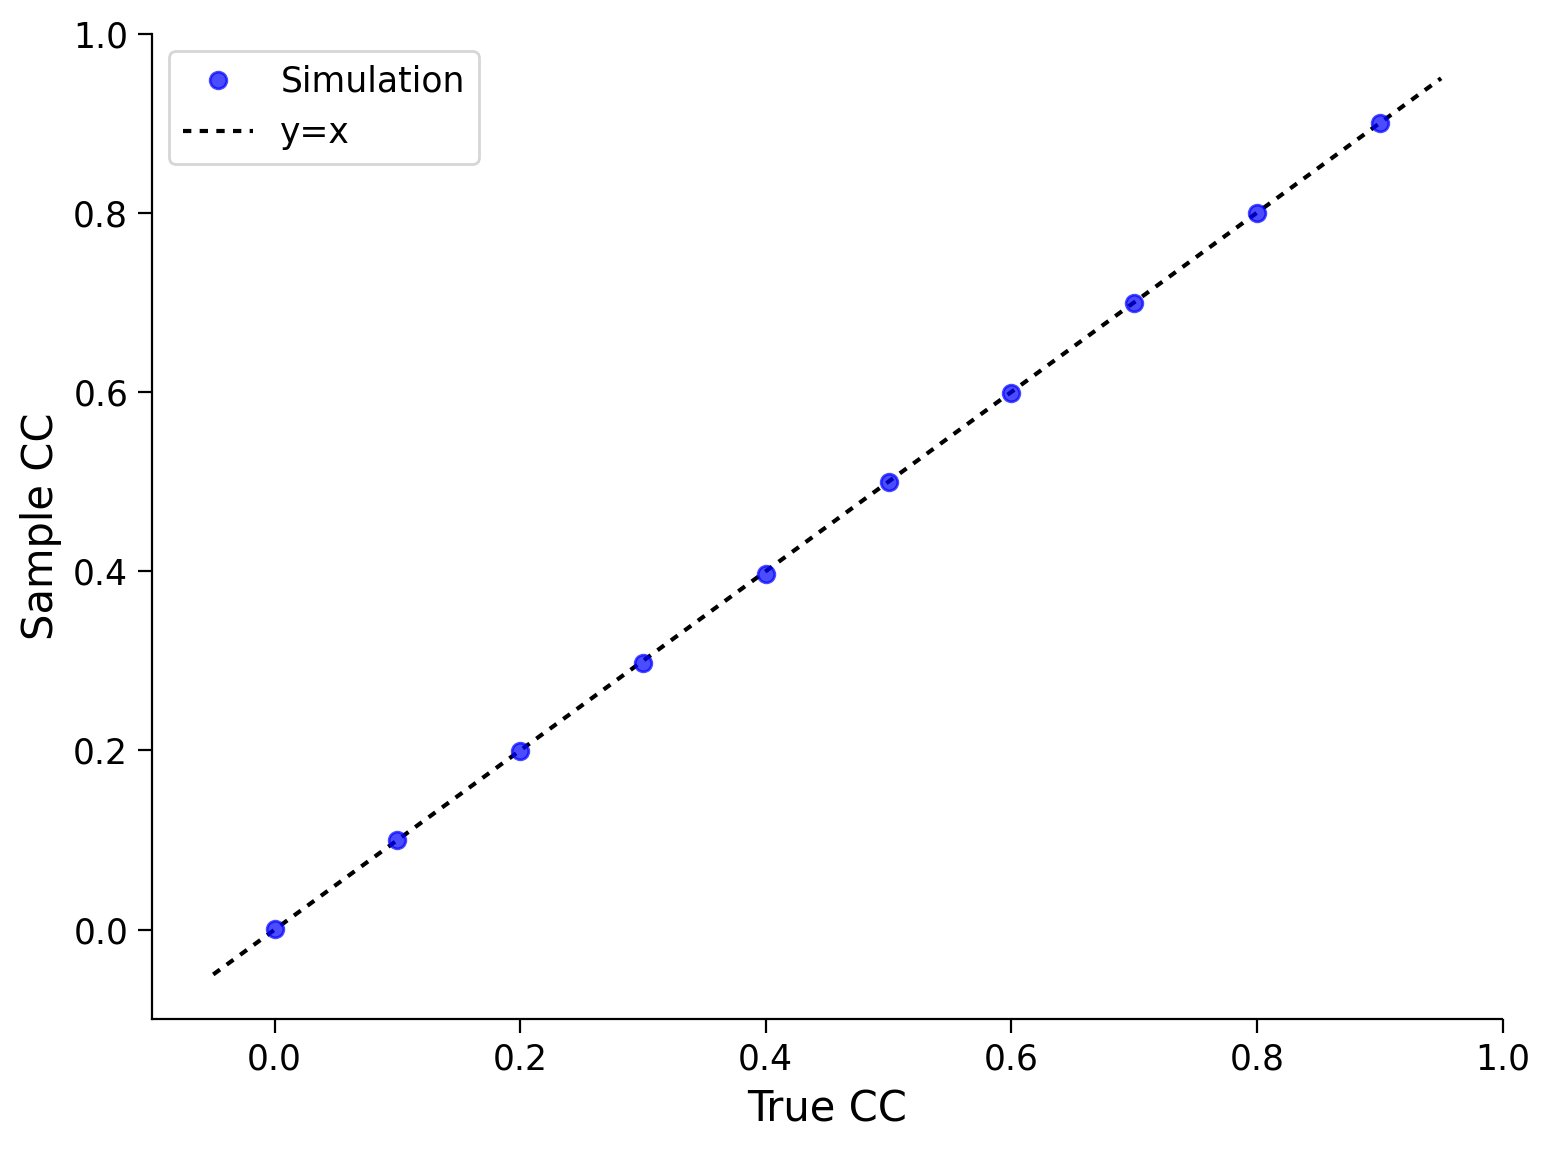

In [21]:
def my_CC(i, j):
  """
  Args:
    i, j  : two time series with the same length

  Returns:
    rij   : correlation coefficient
  """
  ########################################################################
  # Tip1: array([a1, a2, a3])*array([b1, b2, b3]) = array([a1*b1, a2*b2, a3*b3])
  # Tip2: np.sum(array([a1, a2, a3])) = a1+a2+a3
  # Tip3: square root, np.sqrt()
  ########################################################################

  return np.corrcoef(i, j)[0, 1]


example_plot_myCC()

In [26]:
# @markdown Execute this cell to get helper function `Poisson_generator`
def Poisson_generator(pars, rate, n, myseed=False):
  """
  Generates poisson trains

  Args:
    pars       : parameter dictionary
    rate       : noise amplitute [Hz]
    n          : number of Poisson trains
    myseed     : random seed. int or boolean

  Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                      there is a spike in ith spike train over time
                      (1 if spike, 0 otherwise)
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate uniformly distributed random variables
  u_rand = np.random.rand(n, Lt)

  # generate Poisson train
  poisson_train = 1. * (u_rand < rate * (dt / 1000.))

  return poisson_train

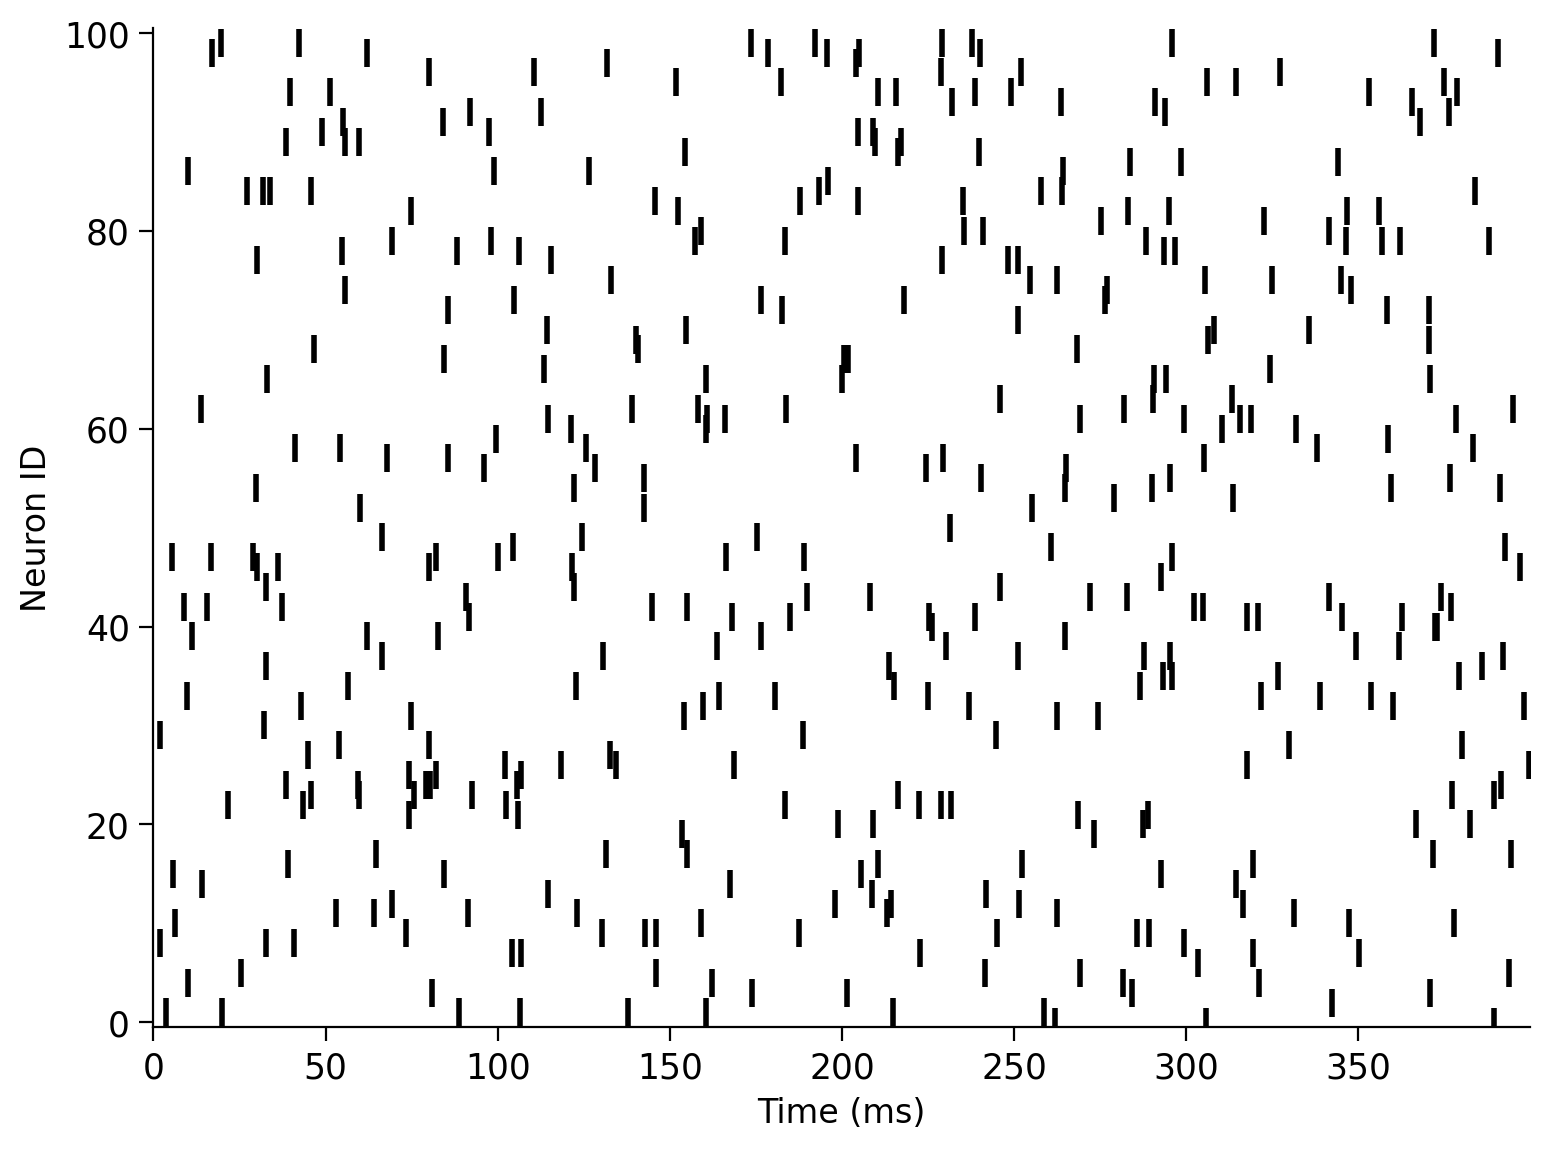

In [27]:
# @markdown Execute this cell to visualize Poisson spike train

pars = default_pars()
pre_spike_train = Poisson_generator(pars, rate=10, n=100, myseed=2020)
my_raster_Poisson(pars['range_t'], pre_spike_train, 100)

In [29]:
def generate_corr_Poisson(pars, poi_rate, c, myseed=False):
  """
  function to generate correlated Poisson type spike trains
  Args:
    pars       : parameter dictionary
    poi_rate   : rate of the Poisson train
    c.         : correlation coefficient ~[0, 1]

  Returns:
    sp1, sp2   : two correlated spike time trains with corr. coe. c
  """

  range_t = pars['range_t']

  mother_rate = poi_rate / c
  mother_spike_train = Poisson_generator(pars, rate=mother_rate,
                                         n=1, myseed=myseed)[0]
  sp_mother = range_t[mother_spike_train > 0]

  L_sp_mother = len(sp_mother)
  sp_mother_id = np.arange(L_sp_mother)
  L_sp_corr = int(L_sp_mother * c)

  np.random.shuffle(sp_mother_id)
  sp1 = np.sort(sp_mother[sp_mother_id[:L_sp_corr]])

  np.random.shuffle(sp_mother_id)
  sp2 = np.sort(sp_mother[sp_mother_id[:L_sp_corr]])

  return sp1, sp2

In [30]:
def corr_coeff_pairs(pars, rate, c, trials, bins):
  """
  Calculate the correlation coefficient of two spike trains, for different
  realizations

  Args:
      pars   : parameter dictionary
      rate   : rate of poisson inputs
      c      : correlation coefficient ~ [0, 1]
      trials : number of realizations
      bins   : vector with bins for time discretization

  Returns:
    r12      : correlation coefficient of a pair of inputs
  """

  r12 = np.zeros(trials)

  for i in range(trials):
    ##############################################################
    # Note that you can run multiple realizations and compute their r_12(diff_trials)
    # with the defined function above. The average r_12 over trials can get close to c.
    # Note: change seed to generate different input per trial
     
    ##############################################################

    # Generate correlated Poisson inputs
    sp1, sp2 = generate_corr_Poisson(pars, rate, c, myseed=2020+i)

    # Bin the spike times of the first input
    sp1_count, _ = np.histogram(sp1, bins=bins)

    # Bin the spike times of the second input
    sp2_count, _ = np.histogram(sp2, bins=bins)

    # Calculate the correlation coefficient
    r12[i] = my_CC(sp1_count, sp2_count)

  return r12


poi_rate = 20.
c = 0.2  # set true correlation
pars = default_pars(T=10000)

# bin the spike time
bin_size = 20  # [ms]
my_bin = np.arange(0, pars['T'], bin_size)
n_trials = 100  # 100 realizations

r12 = corr_coeff_pairs(pars, rate=poi_rate, c=c, trials=n_trials, bins=my_bin)
print(f'True corr coe = {c:.3f}')
print(f'Simu corr coe = {r12.mean():.3f}')

True corr coe = 0.200
Simu corr coe = 0.197


Simulation time = 0.01 min
Input correlation = 0.3
Output correlation = 0.1316879926752237


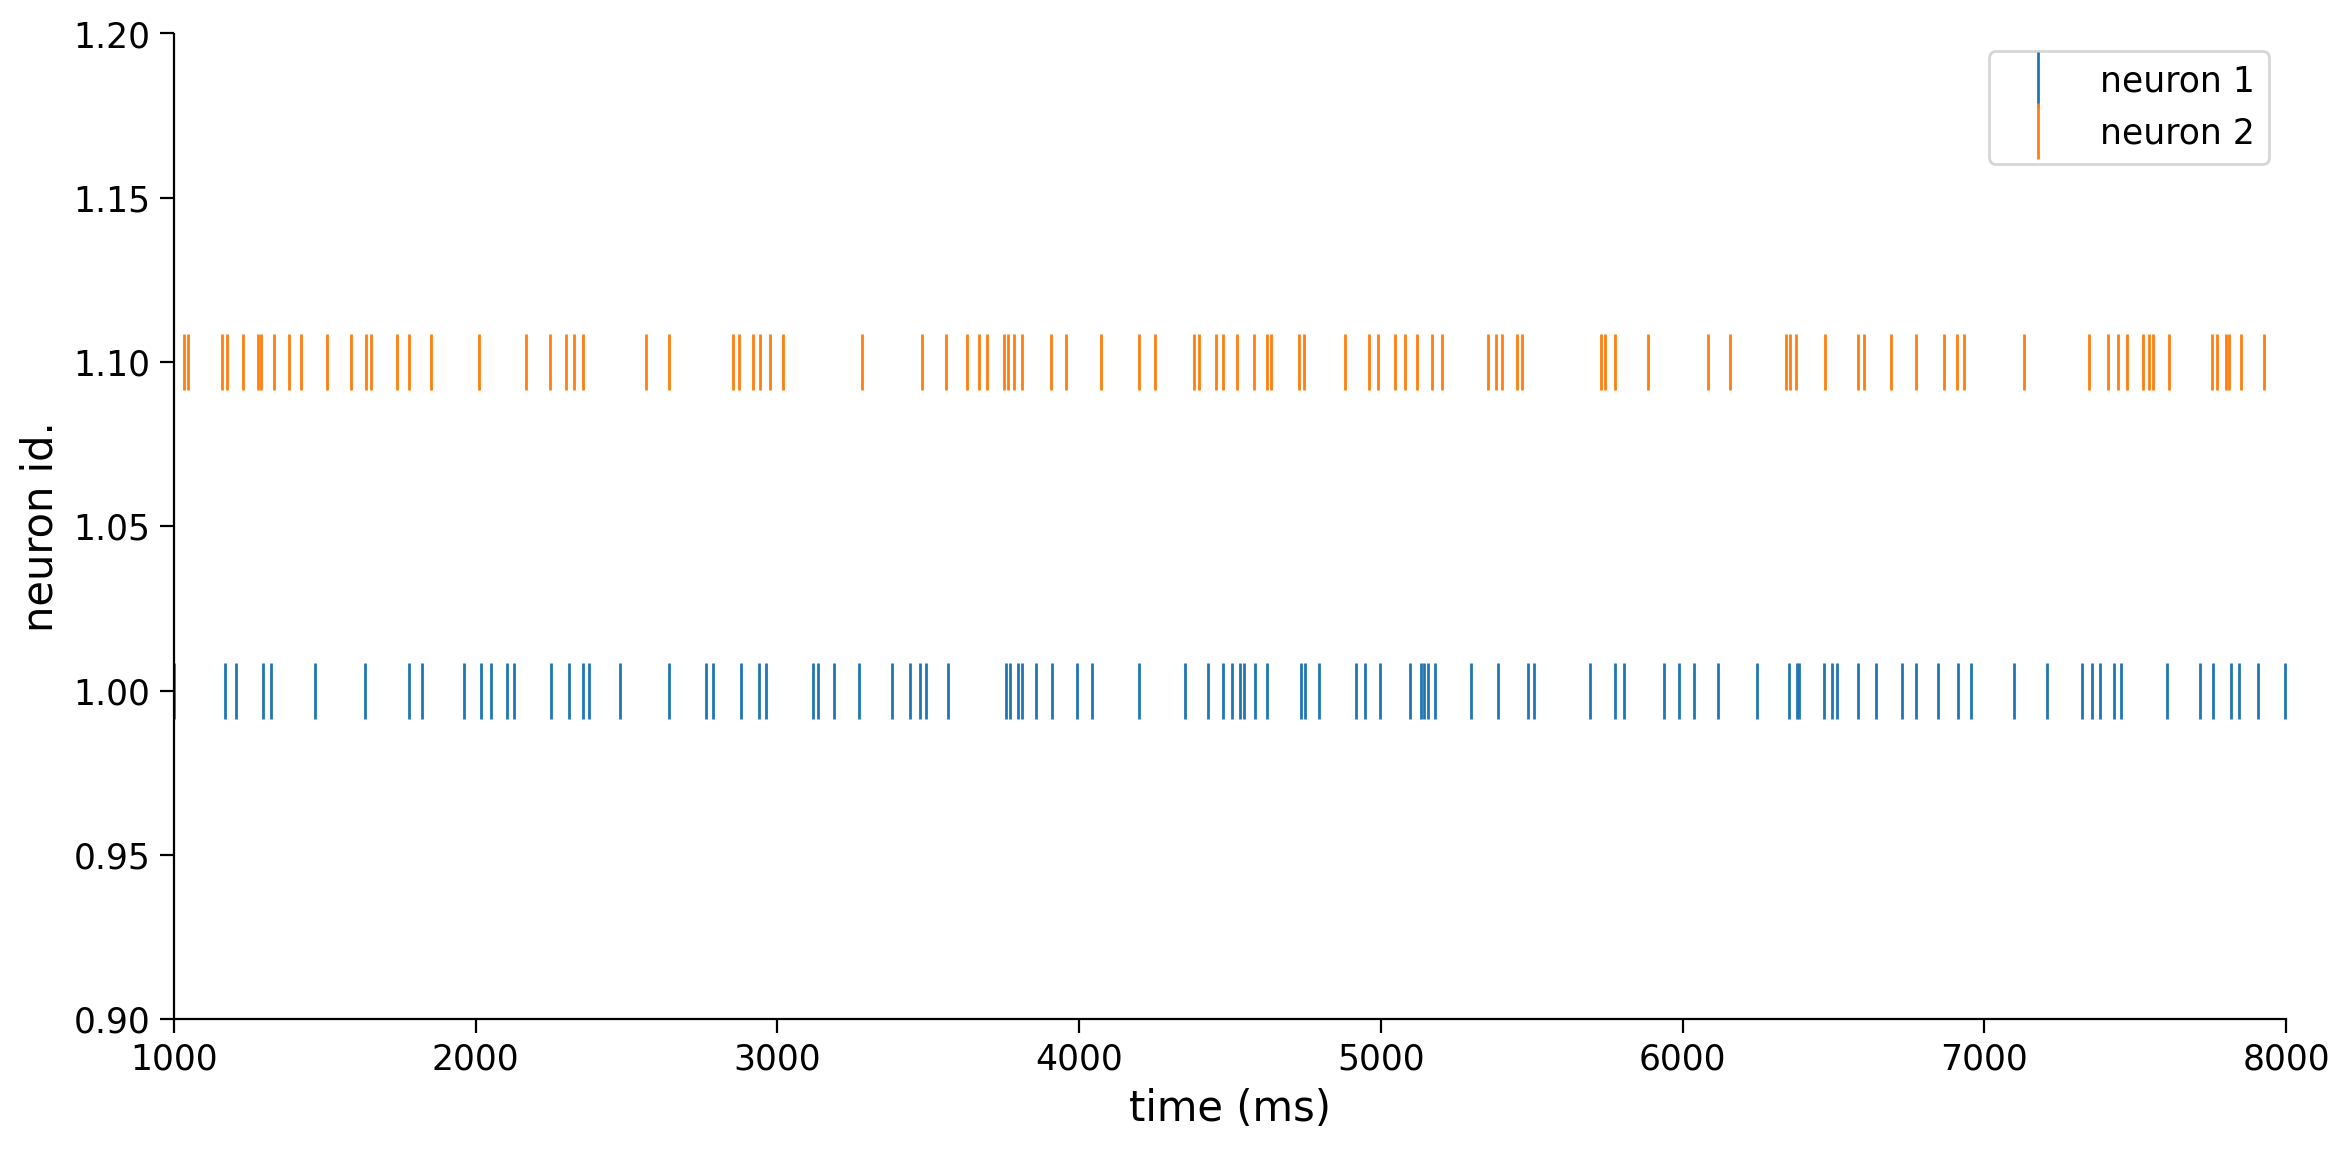

In [31]:
# Play around with these parameters

pars = default_pars(T=80000, dt=1.)  # get the parameters
c_in = 0.3  # set input correlation value
gwn_mean = 10.
gwn_std = 10.


bin_size = 10.  # ms
starttime = time.perf_counter()  # time clock
r12_ss, sp_ss, sp1, sp2 = LIF_output_cc(pars, mu=gwn_mean, sig=gwn_std, c=c_in,
                                        bin_size=bin_size, n_trials=10)

# just the time counter
endtime = time.perf_counter()
timecost = (endtime - starttime) / 60.
print(f"Simulation time = {timecost:.2f} min")

print(f"Input correlation = {c_in}")
print(f"Output correlation = {r12_ss}")

plt.figure(figsize=(12, 6))
plt.plot(sp1, np.ones(len(sp1)) * 1, '|', ms=20, label='neuron 1')
plt.plot(sp2, np.ones(len(sp2)) * 1.1, '|', ms=20, label='neuron 2')
plt.xlabel('time (ms)')
plt.ylabel('neuron id.')
plt.xlim(1000, 8000)
plt.ylim(0.9, 1.2)
plt.legend()
plt.show()

Simulation time = 0.15 min


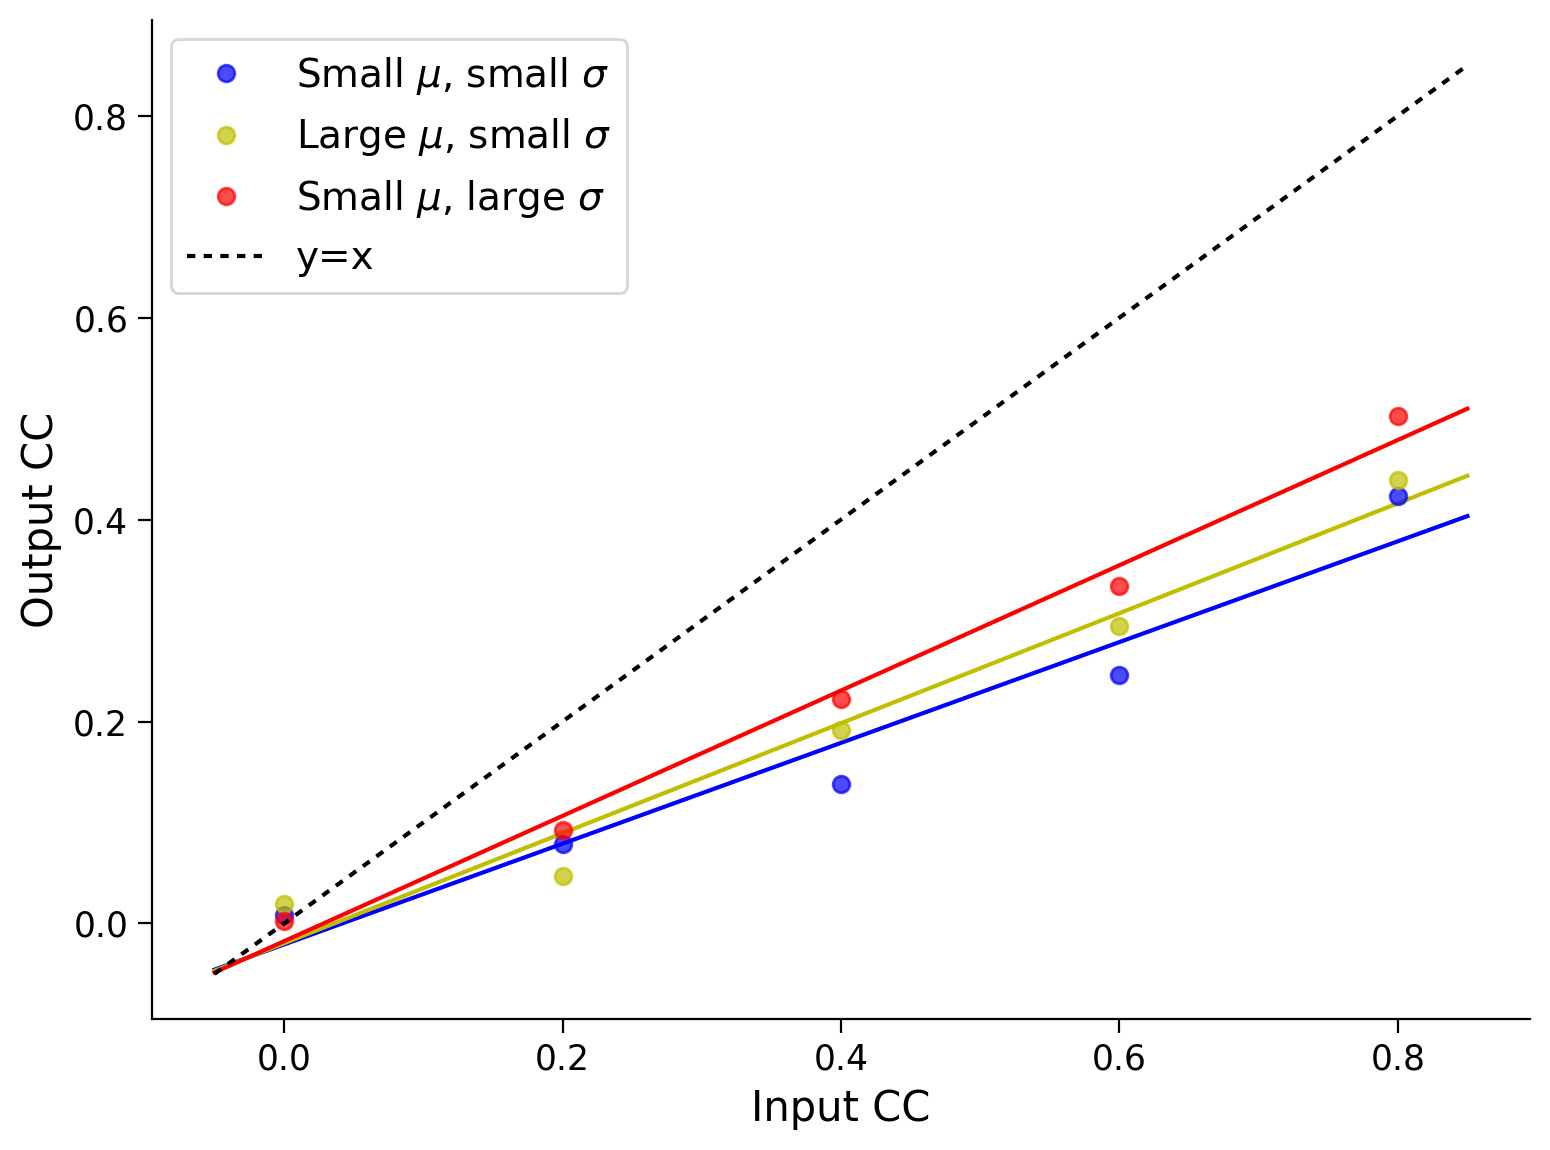

In [32]:
pars = default_pars(T=80000, dt=1.) # get the parameters
n_trials = 10
bin_size = 10.
c_in = np.arange(0., 1., 0.2)  # set the range for input CC
r12_ss = np.zeros(len(c_in))   # small mu, small sigma
r12_ls = np.zeros(len(c_in))   # large mu, small sigma
r12_sl = np.zeros(len(c_in))   # small mu, large sigma

starttime = time.perf_counter()  # time clock
for ic in range(len(c_in)):
  r12_ss[ic], sp_ss, sp1, sp2 = LIF_output_cc(pars, mu=10.0, sig=10.,
                                              c=c_in[ic], bin_size=bin_size,
                                              n_trials=n_trials)
  r12_ls[ic], sp_ls, sp1, sp2 = LIF_output_cc(pars, mu=18.0, sig=10.,
                                              c=c_in[ic], bin_size=bin_size,
                                              n_trials=n_trials)
  r12_sl[ic], sp_sl, sp1, sp2 = LIF_output_cc(pars, mu=10.0, sig=20.,
                                              c=c_in[ic], bin_size=bin_size,
                                              n_trials=n_trials)
endtime = time.perf_counter()
timecost = (endtime - starttime) / 60.
print(f"Simulation time = {timecost:.2f} min")


plot_c_r_LIF(c_in, r12_ss, mycolor='b', mylabel=r'Small $\mu$, small $\sigma$')
plot_c_r_LIF(c_in, r12_ls, mycolor='y', mylabel=r'Large $\mu$, small $\sigma$')
plot_c_r_LIF(c_in, r12_sl, mycolor='r', mylabel=r'Small $\mu$, large $\sigma$')
plt.plot([c_in.min() - 0.05, c_in.max() + 0.05],
         [c_in.min() - 0.05, c_in.max() + 0.05],
         'k--', dashes=(2, 2), label='y=x')
plt.xlabel('Input CC')
plt.ylabel('Output CC')
plt.legend(loc='best', fontsize=14)
plt.show()

#### Synaptic Transmissions

In [33]:
# @title Plotting Functions

def my_illus_LIFSYN(pars, v_fmp, v):
  """
  Illustartion of FMP and membrane voltage

  Args:
    pars  : parameters dictionary
    v_fmp : free membrane potential, mV
    v     : membrane voltage, mV

  Returns:
    plot of membrane voltage and FMP, alongside with the spiking threshold
    and the mean FMP (dashed lines)
  """

  plt.figure(figsize=(14, 5))
  plt.plot(pars['range_t'], v_fmp, 'r', lw=1.,
           label='Free mem. pot.', zorder=2)
  plt.plot(pars['range_t'], v, 'b', lw=1.,
           label='True mem. pot', zorder=1, alpha=0.7)
  plt.axhline(pars['V_th'], 0, 1, color='k', lw=2., ls='--',
              label='Spike Threshold', zorder=1)
  plt.axhline(np.mean(v_fmp), 0, 1, color='r', lw=2., ls='--',
              label='Mean Free Mem. Pot.', zorder=1)
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.legend(loc=[1.02, 0.68])
  plt.show()


def plot_volt_trace(pars, v, sp, show=True):
  """
  Plot trajetory of membrane potential for a single neuron

  Args:
    pars   : parameter dictionary
    v      : volt trajetory
    sp     : spike train

  Returns:
    figure of the membrane potential trajetory for a single neuron
  """

  V_th = pars['V_th']
  dt = pars['dt']
  if sp.size:
    sp_num = (sp/dt).astype(int) - 1
    v[sp_num] += 10

  plt.plot(pars['range_t'], v, 'b')
  plt.axhline(V_th, 0, 1, color='k', ls='--', lw=1.)
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  if show:
    plt.show()


def my_illus_STD(Poisson=False, rate=20., U0=0.5,
                 tau_d=100., tau_f=50., plot_out=True):
  """
   Only for one presynaptic train

  Args:
    Poisson    : Poisson or regular input spiking trains
    rate       : Rate of input spikes, Hz
    U0         : synaptic release probability at rest
    tau_d      : synaptic depression time constant of x [ms]
    tau_f      : synaptic facilitation time constantr of u [ms]
    plot_out   : whether ot not to plot, True or False

  Returns:
    Nothing.
  """

  T_simu = 10.0 * 1000 / (1.0 * rate)  # 10 spikes in the time window
  pars = default_pars(T=T_simu)
  dt = pars['dt']

  if Poisson:
    # Poisson type spike train
    pre_spike_train = Poisson_generator(pars, rate, n=1)
    pre_spike_train = pre_spike_train.sum(axis=0)
  else:
    # Regular firing rate
    isi_num = int((1e3/rate)/dt)  # number of dt
    pre_spike_train = np.zeros(len(pars['range_t']))
    pre_spike_train[::isi_num] = 1.

  u, R, g = dynamic_syn(g_bar=1.2, tau_syn=5., U0=U0,
                        tau_d=tau_d, tau_f=tau_f,
                        pre_spike_train=pre_spike_train,
                        dt=pars['dt'])

  if plot_out:
    plt.figure(figsize=(12, 6))

    plt.subplot(221)
    plt.plot(pars['range_t'], R, 'b', label='R')
    plt.plot(pars['range_t'], u, 'r', label='u')
    plt.legend(loc='best')
    plt.xlim((0, pars['T']))
    plt.ylabel(r'$R$ or $u$ (a.u)')
    plt.subplot(223)
    spT = pre_spike_train > 0
    t_sp = pars['range_t'][spT]  #spike times
    plt.plot(t_sp, 0. * np.ones(len(t_sp)), 'k|', ms=18, markeredgewidth=2)
    plt.xlabel('Time (ms)');
    plt.xlim((0, pars['T']))
    plt.yticks([])
    plt.title('Presynaptic spikes')

    plt.subplot(122)
    plt.plot(pars['range_t'], g, 'r', label='STP synapse')
    plt.xlabel('Time (ms)')
    plt.ylabel('g (nS)')
    plt.xlim((0, pars['T']))

    plt.tight_layout()
    plt.show()

  if not Poisson:
    return g[isi_num], g[9*isi_num]

In [35]:
def run_LIF_cond(pars, I_inj, pre_spike_train_ex, pre_spike_train_in):
  """
  Conductance-based LIF dynamics

  Args:
    pars               : parameter dictionary
    I_inj              : injected current [pA]. The injected current here
                         can be a value or an array
    pre_spike_train_ex : spike train input from presynaptic excitatory neuron
    pre_spike_train_in : spike train input from presynaptic inhibitory neuron

  Returns:
    rec_spikes         : spike times
    rec_v              : mebrane potential
    gE                 : postsynaptic excitatory conductance
    gI                 : postsynaptic inhibitory conductance

  """

  # Retrieve parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, E_L = pars['V_init'], pars['E_L']
  gE_bar, gI_bar = pars['gE_bar'], pars['gI_bar']
  VE, VI = pars['VE'], pars['VI']
  tau_syn_E, tau_syn_I = pars['tau_syn_E'], pars['tau_syn_I']
  tref = pars['tref']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Initialize
  tr = 0.
  v = np.zeros(Lt)
  v[0] = V_init
  gE = np.zeros(Lt)
  gI = np.zeros(Lt)
  Iinj = I_inj * np.ones(Lt)  # ensure Iinj has length Lt

  if pre_spike_train_ex.max() == 0:
    pre_spike_train_ex_total = np.zeros(Lt)
  else:
    pre_spike_train_ex_total = pre_spike_train_ex.sum(axis=0) * np.ones(Lt)

  if pre_spike_train_in.max() == 0:
    pre_spike_train_in_total = np.zeros(Lt)
  else:
    pre_spike_train_in_total = pre_spike_train_in.sum(axis=0) * np.ones(Lt)

  # simulation
  rec_spikes = []  # recording spike times
  for it in range(Lt - 1):
    if tr > 0:
      v[it] = V_reset
      tr = tr - 1
    elif v[it] >= V_th:  # reset voltage and record spike event
      rec_spikes.append(it)
      v[it] = V_reset
      tr = tref / dt

    # update the synaptic conductance
    gE[it + 1] = gE[it] - (dt / tau_syn_E) * gE[it] + gE_bar * pre_spike_train_ex_total[it + 1]
    gI[it + 1] = gI[it] - (dt / tau_syn_I) * gI[it] + gI_bar * pre_spike_train_in_total[it + 1]

    # calculate the increment of the membrane potential
    dv = (dt / tau_m) * (-(v[it] - E_L) \
                         - (gE[it + 1] / g_L) * (v[it] - VE) \
                         - (gI[it + 1] / g_L) * (v[it] - VI) + Iinj[it] / g_L)

    # update membrane potential
    v[it+1] = v[it] + dv

  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes, gE, gI

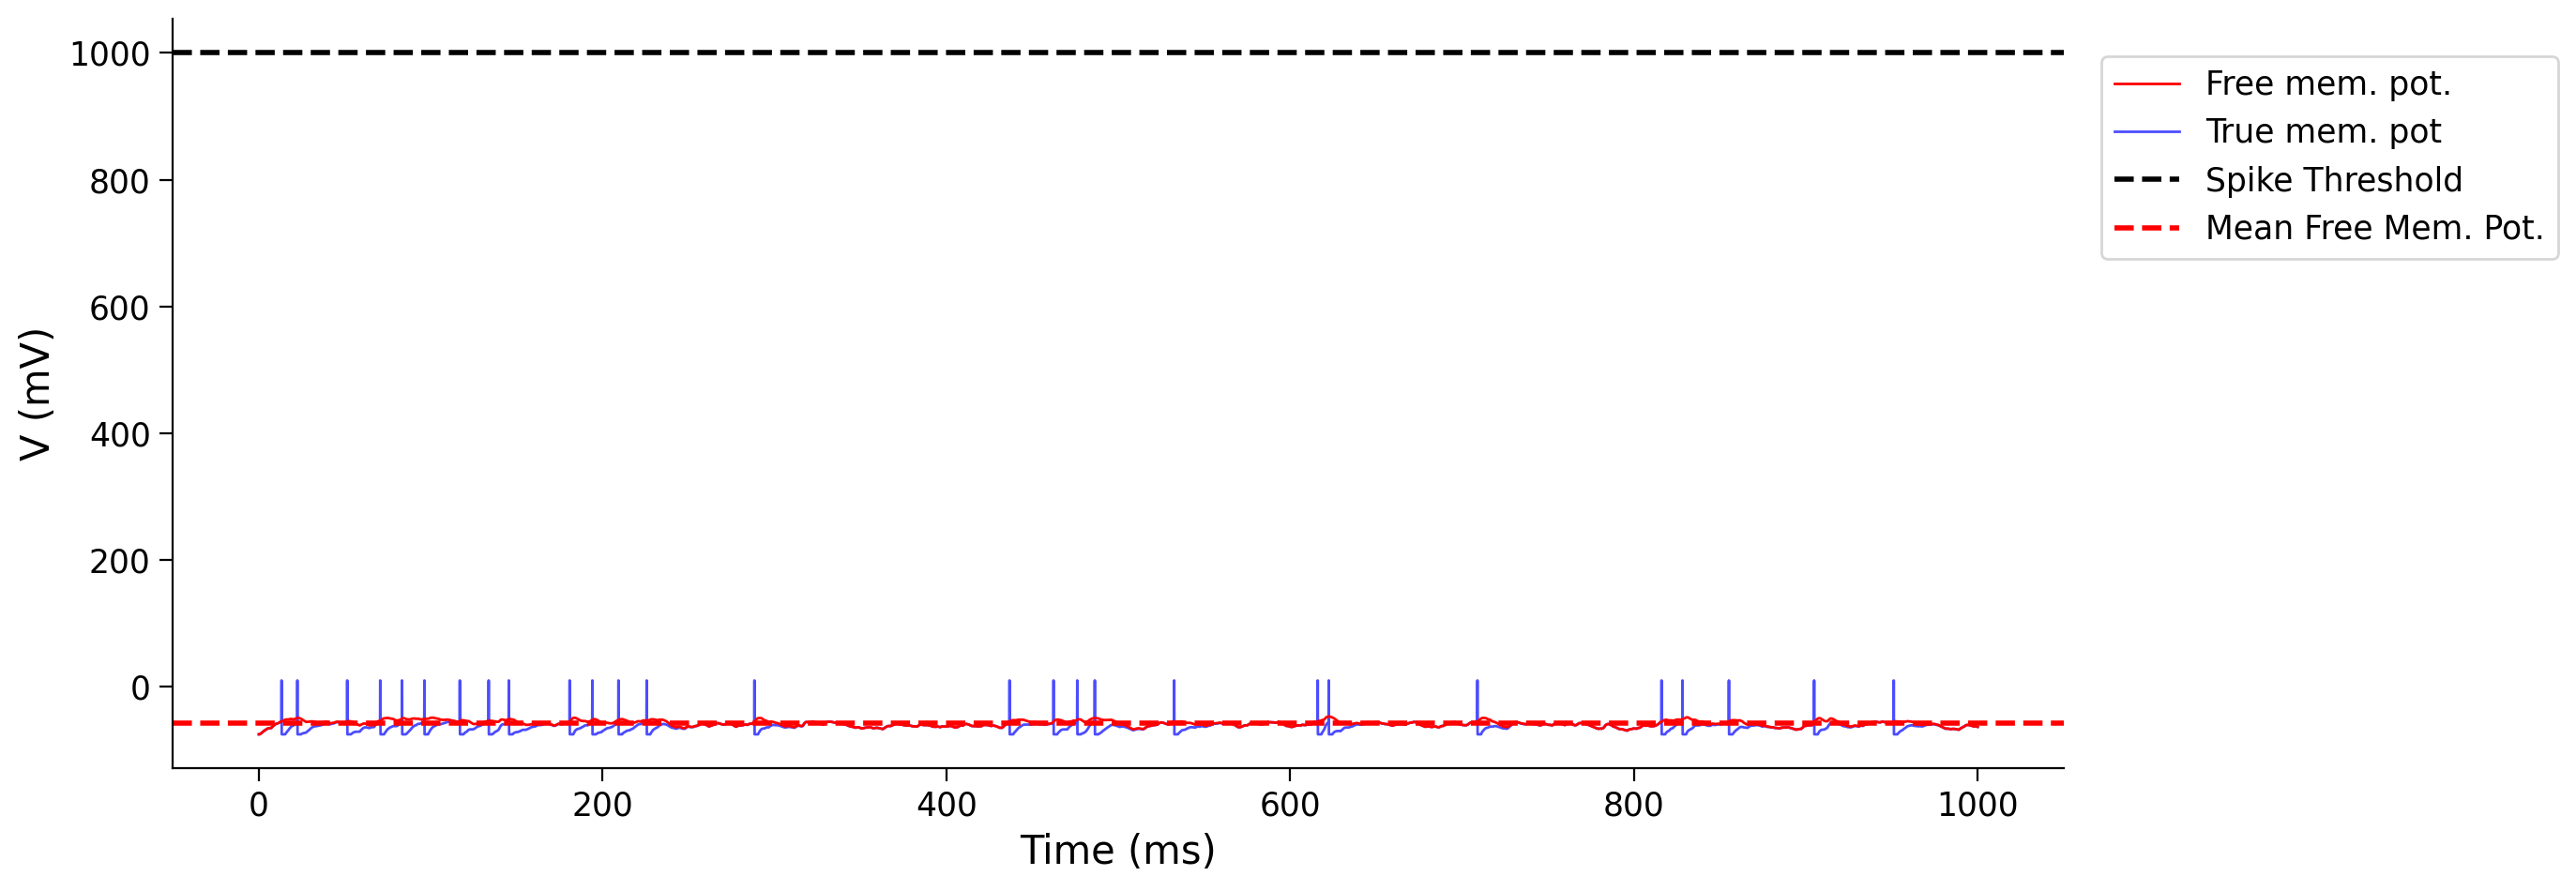

In [36]:
# Get default parameters
pars = default_pars(T=1000.)

# Add parameters
pars['gE_bar'] = 2.4    # [nS]
pars['VE'] = 0.         # [mV] excitatory reversal potential
pars['tau_syn_E'] = 2.  # [ms]
pars['gI_bar'] = 2.4    # [nS]
pars['VI'] = -80.       # [mV] inhibitory reversal potential
pars['tau_syn_I'] = 5.  # [ms]

# Generate presynaptic spike trains
pre_spike_train_ex = Poisson_generator(pars, rate=10, n=80)
pre_spike_train_in = Poisson_generator(pars, rate=10, n=20)

# Simulate conductance-based LIF model
v, rec_spikes, gE, gI = run_LIF_cond(pars, 0, pre_spike_train_ex,
                                     pre_spike_train_in)

# Show spikes more clearly by setting voltage high
dt, range_t = pars['dt'], pars['range_t']
if rec_spikes.size:
  sp_num = (rec_spikes / dt).astype(int) - 1
  v[sp_num] = 10   # draw nicer spikes


# Change the threshold
pars['V_th'] = 1e3

# Calculate FMP
v_fmp, _, _, _ = run_LIF_cond(pars, 0, pre_spike_train_ex, pre_spike_train_in)

my_illus_LIFSYN(pars, v_fmp, v)

In [38]:
def dynamic_syn(g_bar, tau_syn, U0, tau_d, tau_f, pre_spike_train, dt):
  """
  Short-term synaptic plasticity

  Args:
    g_bar           : synaptic conductance strength
    tau_syn         : synaptic time constant [ms]
    U0              : synaptic release probability at rest
    tau_d           : synaptic depression time constant of x [ms]
    tau_f           : synaptic facilitation time constantr of u [ms]
    pre_spike_train : total spike train (number) input
                      from presynaptic neuron
    dt              : time step [ms]

  Returns:
    u               : usage of releasable neurotransmitter
    R               : fraction of synaptic neurotransmitter resources available
    g               : postsynaptic conductance

  """

  Lt = len(pre_spike_train)
  # Initialize
  u = np.zeros(Lt)
  R = np.zeros(Lt)
  R[0] = 1.
  g = np.zeros(Lt)

  # simulation
  for it in range(Lt - 1):
    # Compute du
    du = -(dt / tau_f) * u[it] + U0 * (1.0 - u[it]) * pre_spike_train[it + 1]
    u[it + 1] = u[it] + du
    # Compute dR
    dR = (dt / tau_d) * (1.0 - R[it]) - u[it + 1] * R[it] * pre_spike_train[it + 1]
    R[it + 1] = R[it] + dR
    # Compute dg
    dg = -(dt / tau_syn) * g[it] + g_bar * R[it] * u[it + 1] * pre_spike_train[it + 1]
    g[it + 1] = g[it] + dg

  return u, R, g

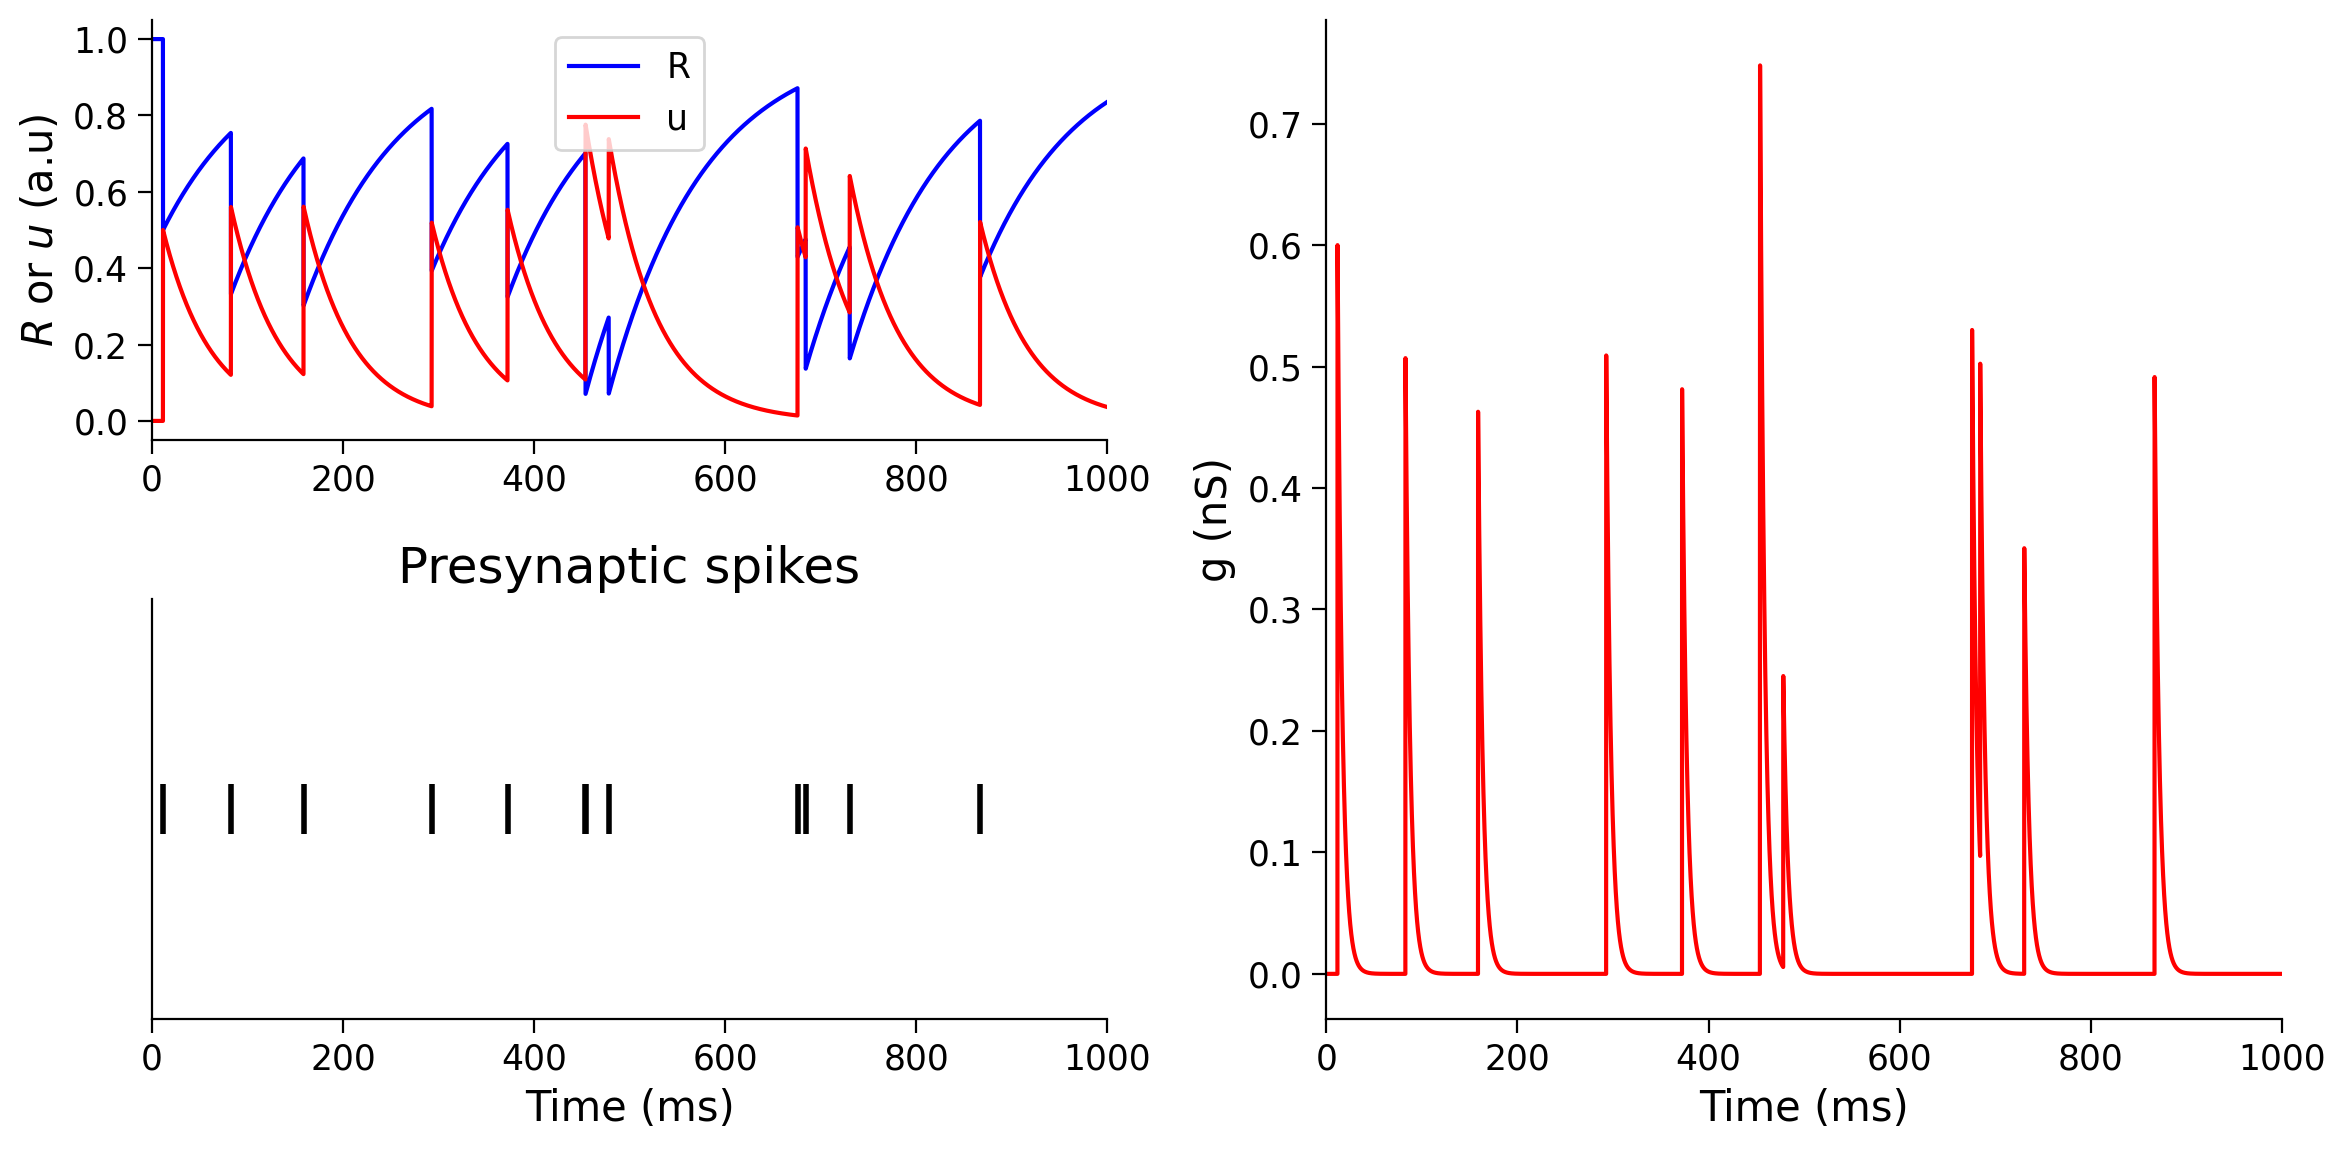

In [39]:
my_illus_STD(True, rate=10)

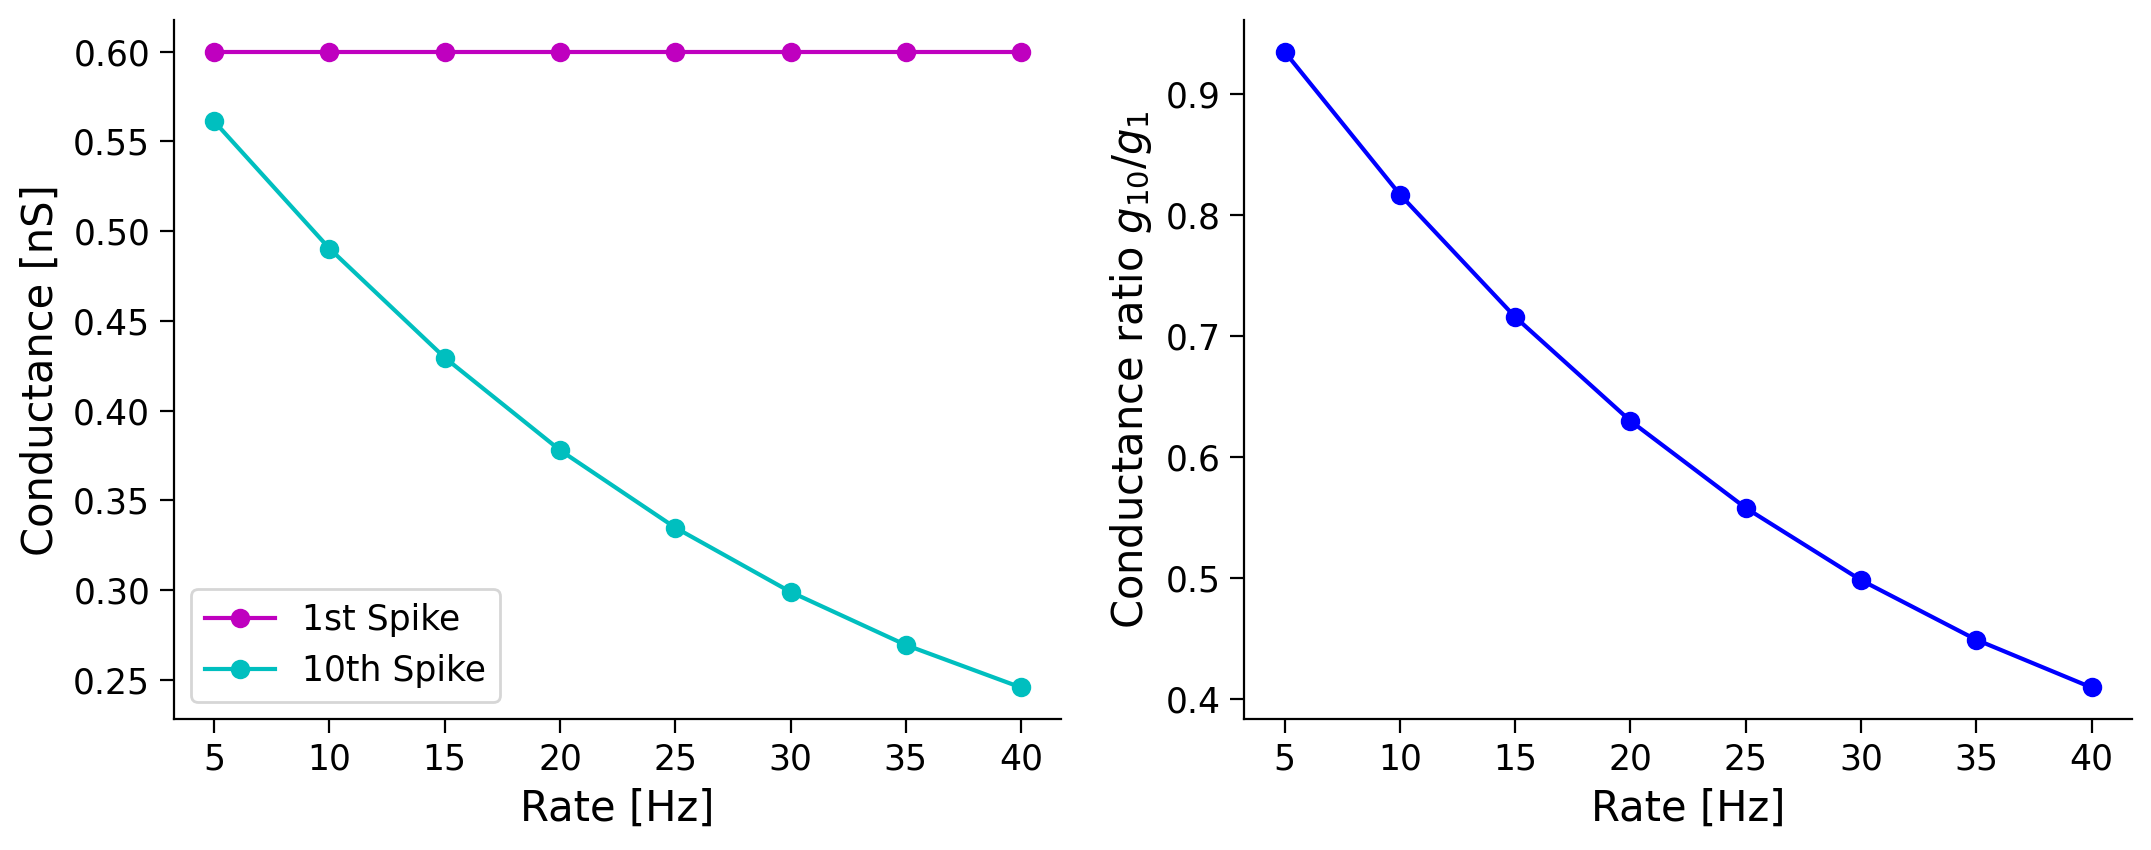

In [40]:
# @markdown STD conductance ratio with different input rate
# Regular firing rate
input_rate = np.arange(5., 40.1, 5.)
g_1 = np.zeros(len(input_rate))  # record the the PSP at 1st spike
g_2 = np.zeros(len(input_rate))  # record the the PSP at 10th spike

for ii in range(len(input_rate)):
   g_1[ii], g_2[ii] = my_illus_STD(Poisson=False, rate=input_rate[ii],
                                   plot_out=False, U0=0.5, tau_d=100., tau_f=50)

plt.figure(figsize=(11, 4.5))

plt.subplot(121)
plt.plot(input_rate, g_1, 'm-o', label='1st Spike')
plt.plot(input_rate, g_2, 'c-o', label='10th Spike')
plt.xlabel('Rate [Hz]')
plt.ylabel('Conductance [nS]')
plt.legend()

plt.subplot(122)
plt.plot(input_rate, g_2 / g_1, 'b-o')
plt.xlabel('Rate [Hz]')
plt.ylabel(r'Conductance ratio $g_{10}/g_{1}$')\

plt.tight_layout()
plt.show()